# Take Home Assignment

##### Submitted by- Shreya Chakravarty
##### Date of submission- 2024/08/12

### Problem Statement

**Time for completion:** 1 day

**Sales data:** (Filename: `sales.csv`)

### Columns and Description

1. **Sku** – product identifier number
2. **product_category** – product category
3. **Transaction_date** – date when sales occurred
4. **Promo_year_id** – number ID for promotional year
5. **Promo_week_number** – number ID for promotional week
6. **Units_sold** – total number of product units sold during the date
7. **Units_revenue** – total $ for units sold during the date

### Problem:

Understand what model produced better results.

### Assignment:

1. Sales contain four weeks of data from `2020/08/28` to `2020/09/24`.
   - Generate a daily forecast of units to be sold for the week `2020/09/25` to `2020/10/01` based on available data for the **category with the highest $ revenue**.

2. Explain why you chose the method you used.
   - Please share your code along with the results and additional explanations as you see fit.

### Additional Questions?

Please make appropriate assumptions regarding data if needed and add the description of the assumptions to your answer.

# Index

1. [Package Installation](#1.-Package-Installation)
2. [Define functions for metrics report](#2.-Define-functions-for-metrics-report)
3. [Read the data](#3.-Read-the-data)
4. [Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)
5. [Finalizing the Dataset](#5.-Finalizing-the-Dataset)
6. [Data Visualization](#6.-Data-Visualization)
7. [Hypothesis Testing](#7.-Hypothesis-Testing)
8. [Differencing to identify the integrator parameter in seasonal models](#8.-Differencing-to-identify-the-integrator-parameter-in-seasonal-models)
9. [Train Test Split](#9.-Train-Test-Split)
10. [Model Selection](#10.-Model-Selection)
    - [SARIMAX](#SARIMAX)
    - [Holt-Winters](#Holt-Winters)
    - [Prophet](#Prophet)
    - [Random Forest](#Random-Forest)
    - [XGBoost Model](#XGBoost-Model)
      - [Feature Importance](#Feature-Importance)
11. [Results Visualization](#11.-Results-Visualization)
12. [Metrics Report](#12.-Metrics-Report)
13. [Predicting the future with SARIMAX](#13.-Predicting-the-future-with-SARIMAX)
14. [Predicting the future with Prophet](#14.-Predicting-the-future-with-Prophet)
15. [Finalzing Results](#15.-Finalzing-Results)
16. [Conclusion](#16.-Conclusion)


### 1. Package Installation

Uncomment the below given lines to install the packages. 


In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install statsmodels
# !pip install xgboost
# !pip install scikit-learn
# !pip install prophet
# !pip install plotly
# !pip install seaborn

In [2]:
# This notebook uses python version 3.11.9
!python --version
# %matplotlib inline

Python 3.11.9


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
np.float_ = np.float64
from typing import List, Dict
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import seaborn as sns
from sklearn.model_selection import GridSearchCV

### 2. Define functions for metrics report
Our primary metric of choice for this project will be **MAPE** (Mean Absolute Percentage Error). This metric will help us understand the proportions of error in our predictions.

###### **Assumptions**

1. **MAPE ≤ 10%** : Excellent
2. **10% < MAPE ≤ 20%** : Acceptable
3. **MAPE > 20%** : Needs Improvement


In [4]:
# Function to calculate and display common error metrics (MAE, RMSE, MAPE) for a given model's predictions.
# Inputs:
    # actual_value: List of actual values from the dataset.
    # predictions: List of predicted values from the model.
    # model_name: Name of the model to display in the output.
# Outputs:
    # The function prints the Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) for the given model.

def error_metrics(actual_value: List[float], predictions: List[float], model_name: str) -> None:
    mae: float = mean_absolute_error(actual_value, predictions)
    rmse: float = np.sqrt(mean_squared_error(actual_value, predictions))
    mape: float = mean_absolute_percentage_error(actual_value, predictions)
    print("\nEvaluation Metrics:")
    print(f"MAE for {model_name}: {mae}")
    print(f"RMSE for {model_name}: {rmse}")
    print(f"MAPE for {model_name}: {mape}")

In [5]:
# Function to calculate error metrics (MAE, RMSE, MAPE) for multiple models and determine the best model based on MAPE.
# Inputs:
    #   test_data: A pandas Series containing the actual values from the test dataset.
    #   predictions_metrics: A dictionary where keys are model names (strings) and values are numpy arrays of predicted values from each model.
# Outputs:
    #   The function returns a pandas DataFrame with the calculated metrics (MAE, RMSE, MAPE) for each model.
    #   It also prints the name of the best model based on the lowest Mean Absolute Percentage Error (MAPE).

def calculate_error_metrics(test_data: pd.Series, predictions: Dict[str, np.ndarray]) -> pd.DataFrame:
    metrics = {
        'Model': [],
        'MAE': [],
        'RMSE': [],
        'MAPE': []
    }

    for model_name, preds in predictions.items():
        mae = mean_absolute_error(test_data, preds)
        rmse = np.sqrt(mean_squared_error(test_data, preds))
        mape = mean_absolute_percentage_error(test_data, preds)

        metrics['Model'].append(model_name)
        metrics['MAE'].append(mae)
        metrics['RMSE'].append(rmse)
        metrics['MAPE'].append(mape)
    
    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    # Determine the best model based on the lowest MAPE
    best_model = metrics_df.loc[metrics_df['MAPE'].idxmin(), 'Model']
    
    print(f"The best model based on MAPE is: {best_model}")
    return metrics_df

In [6]:
# Plots the actual vs. predicted data for a given model.

# Parameters:
# - model_name: The name of the model used for predictions.

def custom_plot(model_name: str) -> None:
    plt.title(f'Actual vs Predicted Units Sold in 4th Week - {model_name} Model')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')

    # Rotate date labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 3. Read the data

In [7]:
df = pd.read_csv(r"sales.csv")
print(df['PROMO_YEAR_ID'].unique())
df.head()

[2021]


,sku,product_category,TRANSACTION_DATE,PROMO_YEAR_ID,PROMO_WEEK_NUMBER,units_sold,units_revenue
0,68305839534,ORAL CARE,2020-09-19,2021,26,25.0,58.58
1,817513010132,HAIR CARE,2020-09-19,2021,26,1.0,18.99
2,56100029274,ORAL CARE,2020-09-19,2021,26,39.0,175.11
3,309976768021,MASS COLOR COSMETICS,2020-09-19,2021,26,3.0,47.97
4,64541300623,COUGH & COLD,2020-09-19,2021,26,15.0,136.15


In [8]:
df.shape

(532030, 7)

In [9]:
# data types of all columns

print(df.columns, df.dtypes)

Index(['sku', 'product_category', 'TRANSACTION_DATE', 'PROMO_YEAR_ID',
       'PROMO_WEEK_NUMBER', 'units_sold', 'units_revenue'],
      dtype='object') sku                    int64
product_category      object
TRANSACTION_DATE      object
PROMO_YEAR_ID          int64
PROMO_WEEK_NUMBER      int64
units_sold           float64
units_revenue        float64
dtype: object


In [10]:
# "TRANSACTION_DATE" is supposed to be a date-field, and "units_sold" must be a whole number value

df['units_sold'] = df['units_sold'].astype('int64')
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

In [11]:
print(df.columns, df.dtypes)

Index(['sku', 'product_category', 'TRANSACTION_DATE', 'PROMO_YEAR_ID',
       'PROMO_WEEK_NUMBER', 'units_sold', 'units_revenue'],
      dtype='object') sku                           int64
product_category             object
TRANSACTION_DATE     datetime64[ns]
PROMO_YEAR_ID                 int64
PROMO_WEEK_NUMBER             int64
units_sold                    int64
units_revenue               float64
dtype: object


In [12]:
# dropping 'sku', 'PROMO_YEAR_ID', 'PROMO_WEEK_NUMBER'
# - sku is an ID
# - 'PROMO_YEAR_ID' is an ID, so it is unnecessary since the data is in the same year and only has 4 weeks of records
# - 'PROMO_WEEK_NUMBER' is the week number of the year, showing no seasonal importance

df = df.drop(['sku', 'PROMO_YEAR_ID', 'PROMO_WEEK_NUMBER'], axis=1)
df.head(15)

,product_category,TRANSACTION_DATE,units_sold,units_revenue
0,ORAL CARE,2020-09-19,25,58.58
1,HAIR CARE,2020-09-19,1,18.99
2,ORAL CARE,2020-09-19,39,175.11
3,MASS COLOR COSMETICS,2020-09-19,3,47.97
4,COUGH & COLD,2020-09-19,15,136.15
5,DIGESTIVE,2020-09-19,43,485.49
6,MASS COLOR COSMETICS,2020-09-19,5,49.68
7,BATH,2020-09-19,40,299.10
8,VITAMINS & HERBALS,2020-09-19,7,67.94
9,SALTY SNACKS,2020-09-19,38,135.02


### 4. Exploratory Data Analysis

In [13]:
print(f"Latest Transaction Date: {df['TRANSACTION_DATE'].max()}\n")
print(f"Earliest Transaction Date: {df['TRANSACTION_DATE'].min()}\n")
print(f"Product Categories: {df['product_category'].unique()}")

Latest Transaction Date: 2020-09-24 00:00:00

Earliest Transaction Date: 2020-08-28 00:00:00

Product Categories: ['ORAL CARE' 'HAIR CARE' 'MASS COLOR COSMETICS' 'COUGH & COLD' 'DIGESTIVE'
 'BATH' 'VITAMINS & HERBALS' 'SALTY SNACKS' 'INCONTINENCE' 'BEVERAGES'
 'SHAVE' 'FRAGRANCES' 'SKINCARE' 'CONFECTION' 'AP/DEO' 'APPAREL'
 'NAIL CARE' 'BABY ACCESSORIES' 'HAIR COLOUR' 'REFRIG/DAIRY' 'SOAP'
 'DIABETES' 'BABY FOOD' 'LIP CARE' 'AUDIO/VIDEO' 'PREPARED FOOD'
 'BEAUTY/FASHION' 'BEAUTY ACCESSORIES' 'MEAL REPLACEMENT' 'OPTICAL'
 'BTC PLAN-O-GRAM' 'ANTIHISTAMINES' 'DERM' 'DIABETIC' 'TRIAL AND TRAVEL'
 'FIRST AID' 'FROZEN FOOD' 'STATIONERY' 'FOOT CARE' 'CANDLES' 'FEM CARE'
 'FAMILY PLANNING' 'SMOKE CESSATION' 'MAKEUP ACCESSORIES' 'PET'
 'EYE/EAR CARE' 'ANALGESICS' 'CLEANING' 'DIAPERS & WIPES' 'LAUNDRY'
 'BATTERIES' 'TOYS' 'HOSIERY' 'OTHER GM' 'HARDWARE' 'HOT BEVERAGE'
 'SEASONAL GM' 'COOKIES & CRACKERS' 'BABY HBA' 'CONDIMENTS AND SPICES'
 'SUPPORTS' 'INSECT REPELLENTS' 'PRESTIGE COSMETICS' 'HOUS

##### It is 4 weeks worth of data (28 days)

In [14]:
# looking at no. of transactions per day to notice any spikes

df['TRANSACTION_DATE'].value_counts().sort_index()

TRANSACTION_DATE
2020-08-28    19930
2020-08-29    18801
2020-08-30    17425
2020-08-31    19080
2020-09-01    20439
2020-09-02    19101
2020-09-03    19370
2020-09-04    20241
2020-09-05    18943
2020-09-06    17605
2020-09-07    15740
2020-09-08    20220
2020-09-09    19053
2020-09-10    19443
2020-09-11    19740
2020-09-12    18860
2020-09-13    17480
2020-09-14    18712
2020-09-15    20195
2020-09-16    18912
2020-09-17    19416
2020-09-18    20204
2020-09-19    19026
2020-09-20    17572
2020-09-21    18575
2020-09-22    20010
2020-09-23    18871
2020-09-24    19066
Name: count, dtype: int64

In [15]:
# looking at no. of transactions per category

df['product_category'].value_counts()

product_category
MASS COLOR COSMETICS             61456
SKINCARE                         27203
HAIR CARE                        25293
VITAMINS & HERBALS               24332
NAIL CARE                        19828
                                 ...  
HOUSEHOLD APPLIANCE                  5
INJECTIONS AND VACCINES              4
OPEN DEPARTMENT HHC & DEPOSIT        4
ACQUISITION - CONVENIENCE            1
HOME ASSIST                          1
Name: count, Length: 95, dtype: int64

### 5. Finalizing the Dataset

In [16]:
# Step 1: Aggregate the revenue by product category

revenue_by_category = df.groupby('product_category')['units_revenue'].sum().sort_values()
print(f"Revenue by Category\n-------------\n{revenue_by_category}")

Revenue by Category
-------------
product_category
ACQUISITION - CONVENIENCE          3.29
HOME ASSIST                        3.59
HOUSEHOLD APPLIANCE              114.22
INJECTIONS AND VACCINES          360.96
ACQUISITION - BEAUTY             467.73
                                ...    
ORAL CARE                    1685574.70
FIRST AID                    1755068.24
SKINCARE                     1812669.40
ANALGESICS                   2227885.07
VITAMINS & HERBALS           2845077.36
Name: units_revenue, Length: 95, dtype: float64


In [17]:
# Step 2: To answer the 1st question, identify the category with the highest total revenue

max_revenue_category = revenue_by_category.idxmax()
print(f"Maximum Revenue Category: {max_revenue_category}")

Maximum Revenue Category: VITAMINS & HERBALS


In [18]:
# Step 3: Mask the DataFrame to only include data from this category

df_max_revenue_category = df[df['product_category'] == max_revenue_category]
df_max_revenue_category.head()

,product_category,TRANSACTION_DATE,units_sold,units_revenue
8,VITAMINS & HERBALS,2020-09-19,7,67.94
11,VITAMINS & HERBALS,2020-09-19,34,326.30
18,VITAMINS & HERBALS,2020-09-19,23,462.77
25,VITAMINS & HERBALS,2020-09-19,10,136.76
37,VITAMINS & HERBALS,2020-09-19,3,41.98


#####  Since all values of "product_category" are the same after masking the dataset, and additionally, the only role of revenue was to identify the category that generates it the most, we can drop these columns. We may also notice that revenue and sold items will be proportionate since it will be the price per unit multiple of the number of sold items.

In [19]:
# Step 4: Drop unnecessary columns

final_df = df_max_revenue_category.drop(['units_revenue', 'product_category'], axis=1)
final_df = final_df.groupby(['TRANSACTION_DATE']).sum().reset_index()
print(f"Shape of the dataset: {final_df.shape}")
final_df.head()

Shape of the dataset: (28, 2)


,TRANSACTION_DATE,units_sold
0,2020-08-28,6552
1,2020-08-29,5315
2,2020-08-30,4141
3,2020-08-31,5837
4,2020-09-01,9920


### 6. Data Visualization

In [20]:
final_df.set_index('TRANSACTION_DATE', inplace=True)
final_df.head()

,units_sold
TRANSACTION_DATE,
2020-08-28,6552
2020-08-29,5315
2020-08-30,4141
2020-08-31,5837
2020-09-01,9920


In [21]:
# Names of the days to better notice the behavious of data

# Ensure the index is a DatetimeIndex
final_df.index = pd.to_datetime(final_df.index)

# Add a new column with the names of the days
final_df['Day'] = final_df.index.strftime('%A')

# Display the DataFrame to check the new column
final_df.head(14)

,units_sold,Day
TRANSACTION_DATE,,
2020-08-28,6552,Friday
2020-08-29,5315,Saturday
2020-08-30,4141,Sunday
2020-08-31,5837,Monday
2020-09-01,9920,Tuesday
2020-09-02,5744,Wednesday
2020-09-03,5337,Thursday
2020-09-04,6975,Friday
2020-09-05,5565,Saturday


In [22]:
final_df = final_df.drop('Day', axis=1)

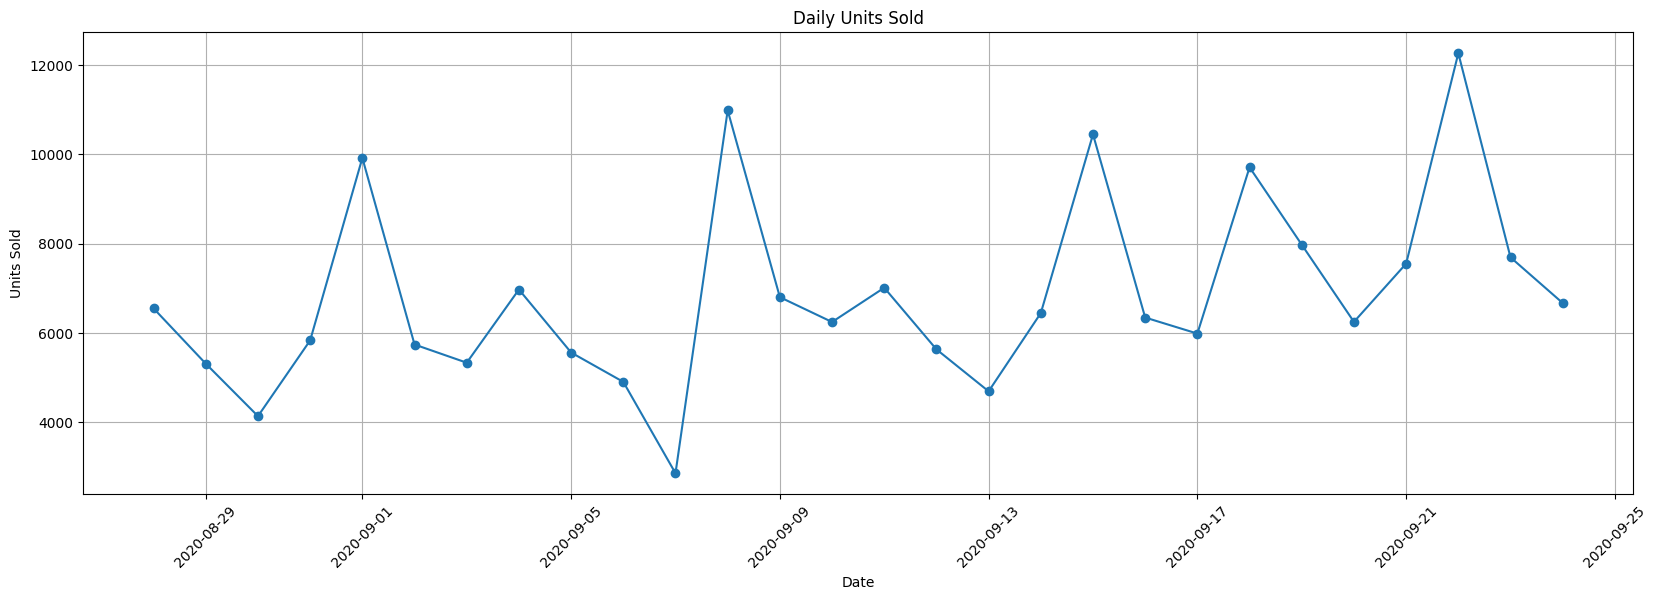

In [23]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(final_df.index , final_df['units_sold'], marker='o')
plt.title('Daily Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

##### From the above dataframe and visual, we can observe spikes in data every Tuesday, making the seasonality 7 days.

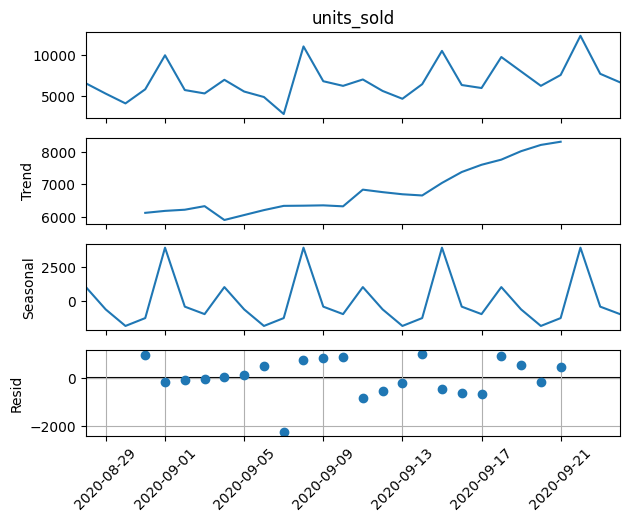

In [24]:
# Visualize the decomposition of the data to identify stationarity (which is essential to apply models like SARIMA)

result = seasonal_decompose(final_df['units_sold'], model='additive')
result.plot()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 7. Hypothesis Testing

#### **Augmented Dickey-Fuller Test**

##### **Hypotheses:**

- **H₀ (Null Hypothesis):** The data has a unit root (non-stationary).
- **Hₐ (Alternate Hypothesis):** The data is stationary.

###### **Key:**
- **H₀** → Null Hypothesis
- **Hₐ** → Alternate Hypothesis


In [25]:
# Performing the Augmented Dickey-Fuller test

result = adfuller(final_df['units_sold'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 1.7227791913328243
p-value: 0.9981829090027664


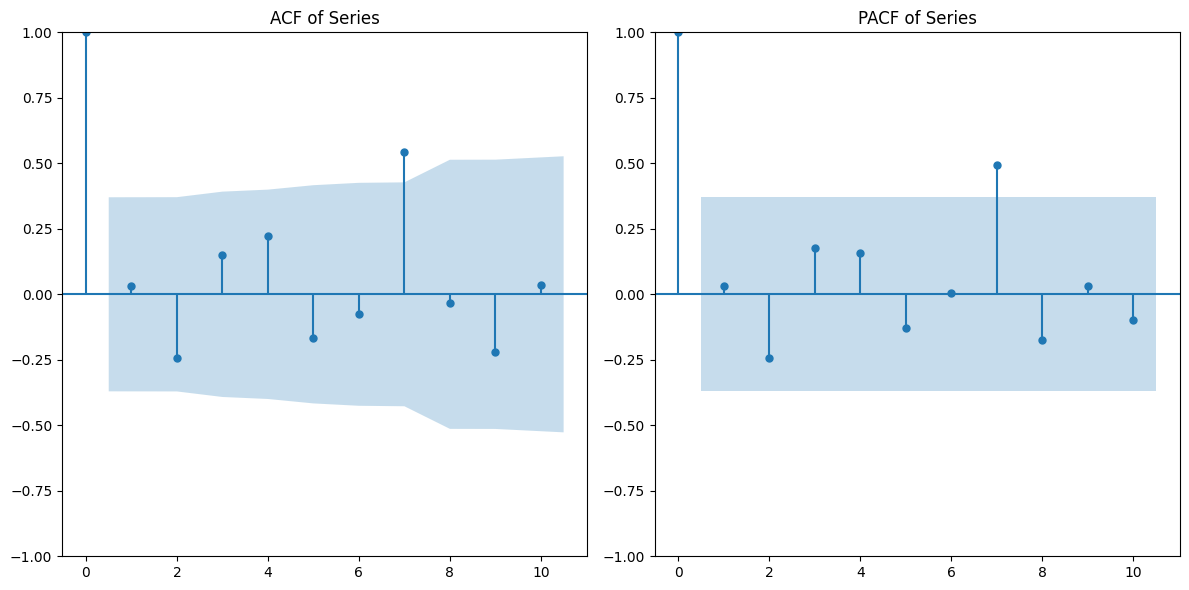

In [26]:
# Plotting the ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(final_df['units_sold'], lags=10, ax=plt.gca())
plt.title('ACF of Series')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(final_df['units_sold'], lags=10, ax=plt.gca())
plt.title('PACF of Series')

plt.tight_layout()
plt.show()


1. **Since the p-value above is greater than the assumed level of significance (0.05), we fail to reject the null hypothesis (H₀).**

2. **The Correlation Function (CF)** shows the correlation between observations at different lags.

3. **The Partial Autocorrelation Function (PACF)** isolates the direct correlation at each lag, helping to determine the appropriate lag values for the model.


### 8. Differencing to identify the integrator parameter in seasonal models

In [27]:
final_df['units_sold_diff'] = final_df['units_sold'].diff().dropna()

# Re-run the ADF test on the differenced data
# dropna() is used to ignore the NaN value in first index since there is no value to difference it from

result_diff = adfuller(final_df['units_sold_diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -6.388604322936754
p-value (Differenced): 2.1334255513838353e-08


1. **Since the p-value above is less than the assumed level of significance (0.05), we reject the null hypothesis (H₀)**, indicating that the data is now **stationary.**

2. **We can infer that the value of I = 1,** as the waveform became stationary after differencing once.


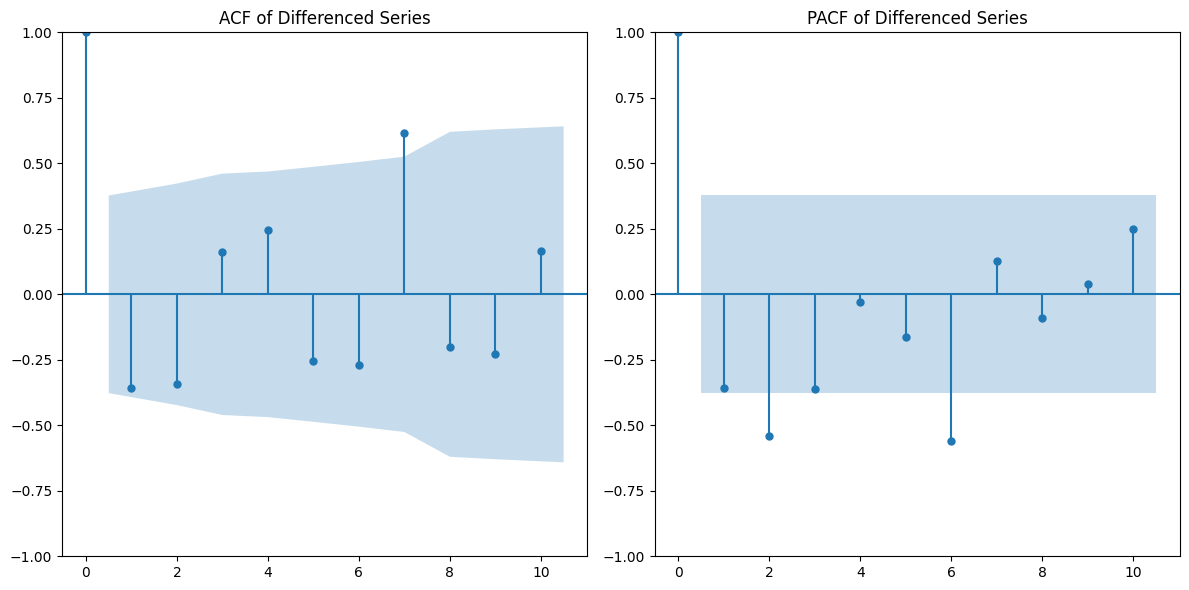

In [28]:
# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(final_df['units_sold'].diff().dropna(), lags=10, ax=plt.gca())
plt.title('ACF of Differenced Series')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(final_df['units_sold'].diff().dropna(), lags=10, ax=plt.gca())
plt.title('PACF of Differenced Series')

plt.tight_layout()
plt.show()


### 9. Train-Test Split

In [29]:
# Defining the training and testing period

train_size = 21  # First 3 weeks (21 days) for training
train_data = final_df['units_sold'].iloc[:train_size]
test_data = final_df['units_sold'].iloc[train_size:]
train_data.shape, test_data.shape

((21,), (7,))

### 10. Model Selection

#### SARIMAX

C:\Users\Shreya\anaconda3_new\envs\TSF\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shreya\anaconda3_new\envs\TSF\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


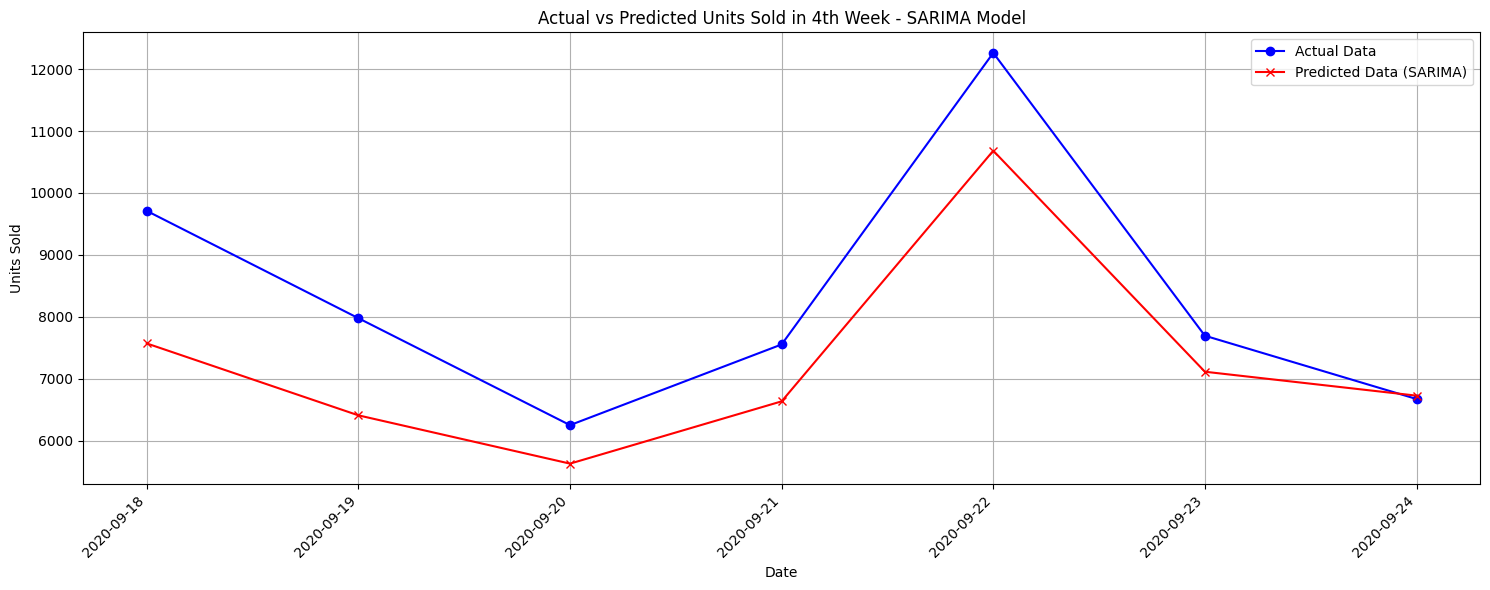


Evaluation Metrics:
MAE for SARIMAX: 1066.509587017746
RMSE for SARIMAX: 1259.9391034407447
MAPE for SARIMAX: 0.12152618907130984


In [30]:
# Fit the SARIMA model (Seasonal ARIMA)
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

# Make predictions for the 4th week
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Plot the actual vs predicted data for the 4th week using SARIMA
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Data', marker='o', color='blue', linestyle='-')
plt.plot(test_data.index, predictions, label='Predicted Data (SARIMA)', marker='x', color='red', linestyle='-')

custom_plot("SARIMA")

error_metrics(test_data, predictions, "SARIMAX")

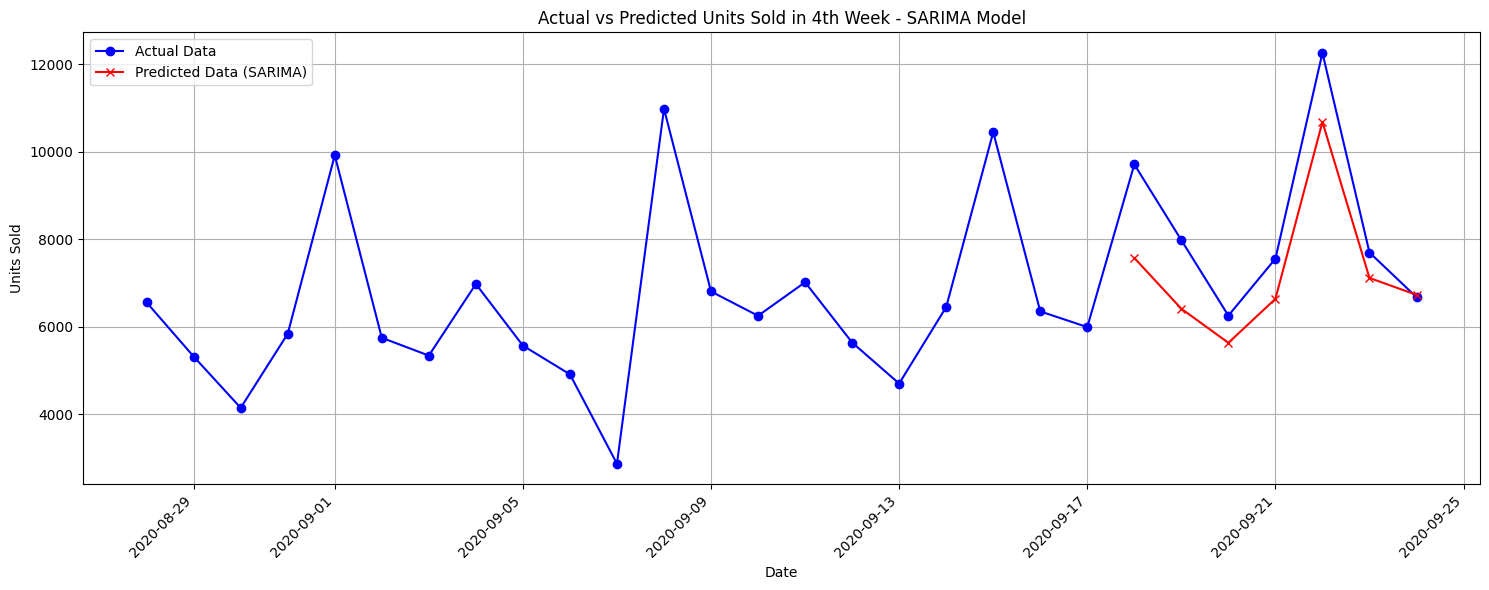

In [31]:
# Plot the entire trend of actual vs predicted data for the 4th week using SARIMA

plt.figure(figsize=(15, 6))
plt.plot(final_df.index, final_df['units_sold'], label='Actual Data', marker='o', color='blue', linestyle='-')
plt.plot(test_data.index, predictions, label='Predicted Data (SARIMA)', marker='x', color='red', linestyle='-')

custom_plot("SARIMA")
# error_metrics(test_data, predictions, "SARIMAX")

#### Holt-Winters

C:\Users\Shreya\anaconda3_new\envs\TSF\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


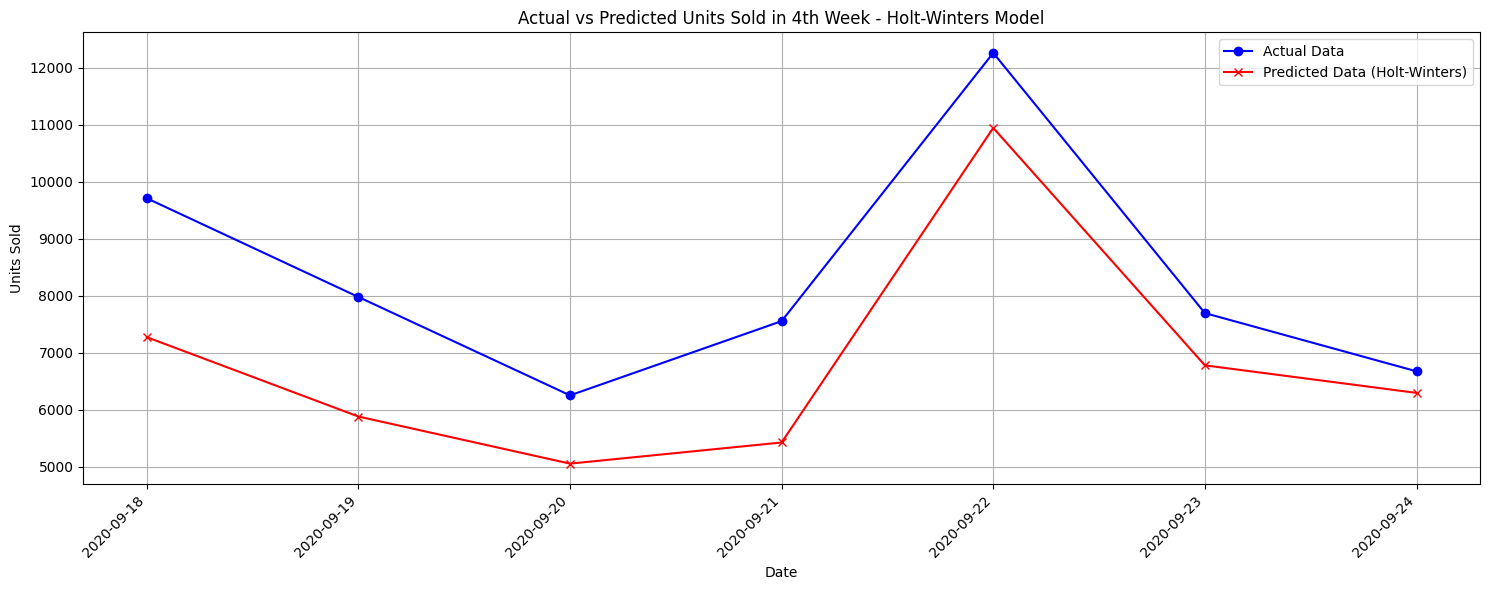


Evaluation Metrics:
MAE for Holt-Winters: 1497.039955918753
RMSE for Holt-Winters: 1649.4373382901583
MAPE for Holt-Winters: 0.18161324037525853


In [32]:
# Holt-Winters Exponential Smoothing
hw_model = ExponentialSmoothing(train_data, seasonal='add', trend='add', seasonal_periods=7)
hw_fit = hw_model.fit()

hw_forecast = hw_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Display the forecast
# Plot of actual vs predicted data for the 4th week using SARIMA
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Data', marker='o', color='blue', linestyle='-')
plt.plot(test_data.index, hw_forecast, label='Predicted Data (Holt-Winters)', marker='x', color='red', linestyle='-')

custom_plot("Holt-Winters")

error_metrics(test_data, hw_forecast, "Holt-Winters")

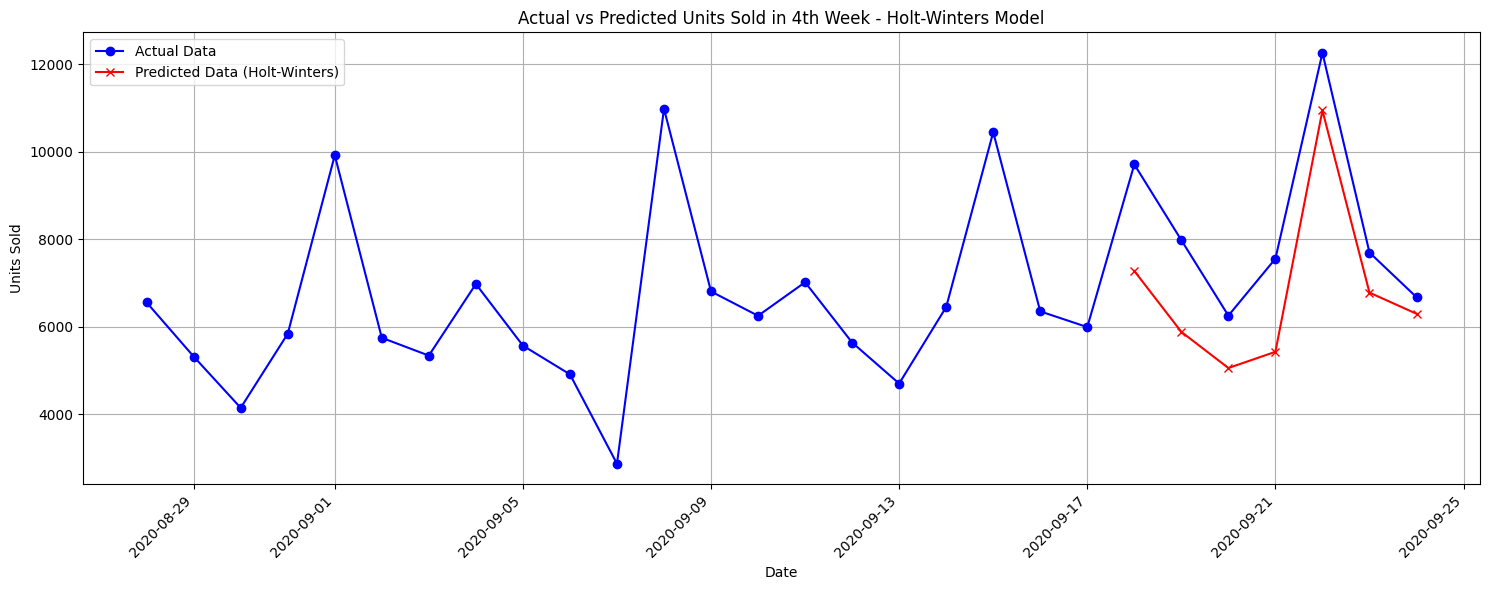

In [33]:
# Plot the entire trend of actual vs predicted data for the 4th week using Holt-Winters

plt.figure(figsize=(15, 6))
plt.plot(final_df.index, final_df['units_sold'], label='Actual Data', marker='o', color='blue', linestyle='-')
plt.plot(test_data.index, hw_forecast, label='Predicted Data (Holt-Winters)', marker='x', color='red', linestyle='-')

custom_plot("Holt-Winters")

#### Prophet

13:02:51 - cmdstanpy - INFO - Chain [1] start processing
13:02:52 - cmdstanpy - INFO - Chain [1] done processing


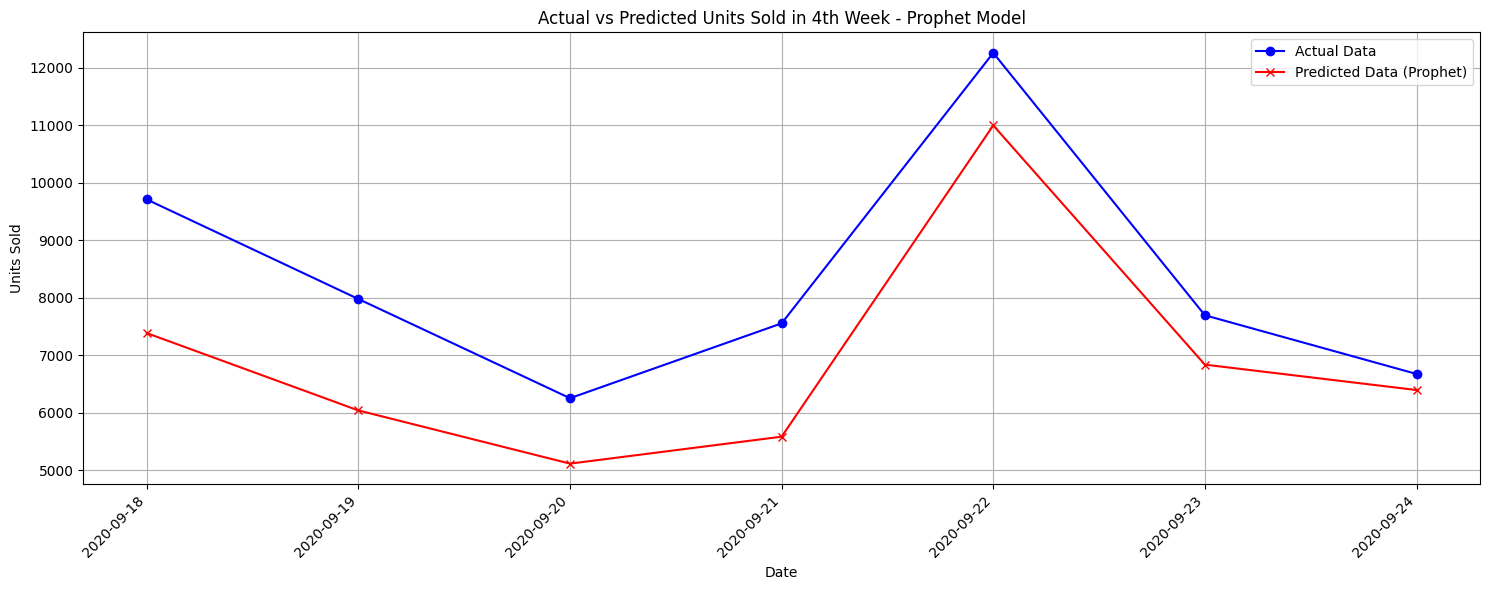


Evaluation Metrics:
MAE for Prophet: 1397.2570922200323
RMSE for Prophet: 1548.2093428251787
MAPE for Prophet: 0.1689697664549579


In [34]:
# Prepare the data for Prophet by renaming the columns to 'ds' (date) and 'y' (target variable).

df_prophet = final_df.reset_index().rename(columns={'TRANSACTION_DATE': 'ds', 'units_sold': 'y'})

prophet_model = Prophet()

prophet_model.fit(df_prophet.iloc[:train_size])

future = prophet_model.make_future_dataframe(periods=7) # to forecast 7 days ahead
forecast = prophet_model.predict(future)
prophet_predictions = forecast['yhat'].iloc[-7:]

# Display the forecast
# Plot the actual vs predicted data for the 4th week using SARIMA
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Data', marker='o', color='blue', linestyle='-')
plt.plot(test_data.index, prophet_predictions, label='Predicted Data (Prophet)', marker='x', color='red', linestyle='-')

custom_plot("Prophet")

error_metrics(test_data, prophet_predictions, "Prophet")

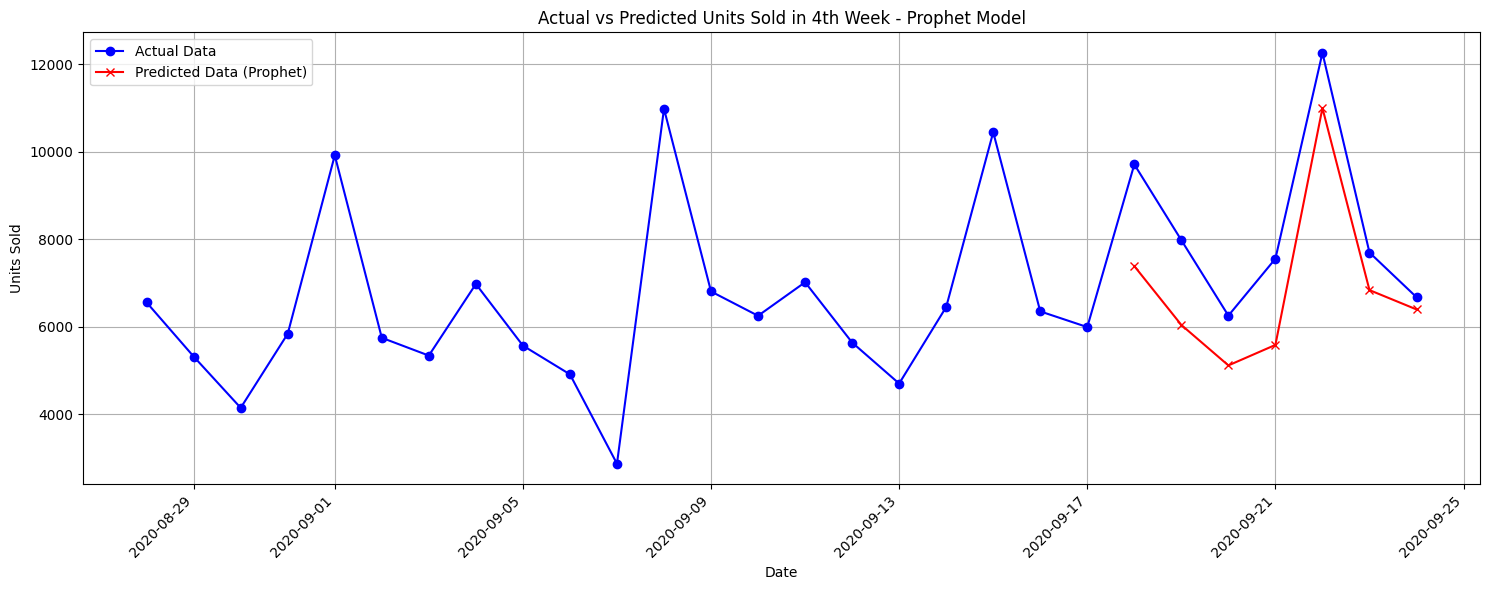

In [35]:
# Display the forecast
# Plot the entire trend of actual vs predicted data for the 4th week using Prophet
plt.figure(figsize=(15, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual Data', marker='o', color='blue', linestyle='-')
plt.plot(test_data.index, prophet_predictions, label='Predicted Data (Prophet)', marker='x', color='red', linestyle='-')

custom_plot("Prophet")

#### Random Forest

##### Feature Engineering- Creating lagged features for the past 7 days to predict the 8th day's output.

###### Adding day-of-week information as a feature. Other features like week or month numbers are excluded due to the limited data (4 weeks), which makes it difficult to capture seasonality correctly.

In [36]:
# creating a copy of final_df to keep the original df intact
df_final = final_df.copy()

# Creating lagged features for the previous 7 days
for i in range(1, 8):
    df_final[f'lag_{i}'] = df_final['units_sold'].shift(i)

# Drop any rows with NaN values resulting from the lagging operation
df_final = df_final.dropna()

# Including "day of week" as an additional feature
df_final['day_of_week'] = df_final.index.dayofweek
df_final.head()

,units_sold,units_sold_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,day_of_week
TRANSACTION_DATE,,,,,,,,,,
2020-09-04,6975,1638.0,5337.0,5744.0,9920.0,5837.0,4141.0,5315.0,6552.0,4
2020-09-05,5565,-1410.0,6975.0,5337.0,5744.0,9920.0,5837.0,4141.0,5315.0,5
2020-09-06,4908,-657.0,5565.0,6975.0,5337.0,5744.0,9920.0,5837.0,4141.0,6
2020-09-07,2863,-2045.0,4908.0,5565.0,6975.0,5337.0,5744.0,9920.0,5837.0,0
2020-09-08,10984,8121.0,2863.0,4908.0,5565.0,6975.0,5337.0,5744.0,9920.0,1


In [37]:
# Split the data: use the last 7 points as the test set
train_df = df_final.iloc[:-7]
test_df = df_final.iloc[-7:]

# Features to use: previous 7 days and day of the week
features = [f'lag_{i}' for i in range(1, 8)] + ['day_of_week']

X_train = train_df[features]
y_train = train_df['units_sold']

X_test = test_df[features]
y_test = test_df['units_sold']

In [38]:
## Performing Grid Search to identify best hyper-parameters for RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500], 
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


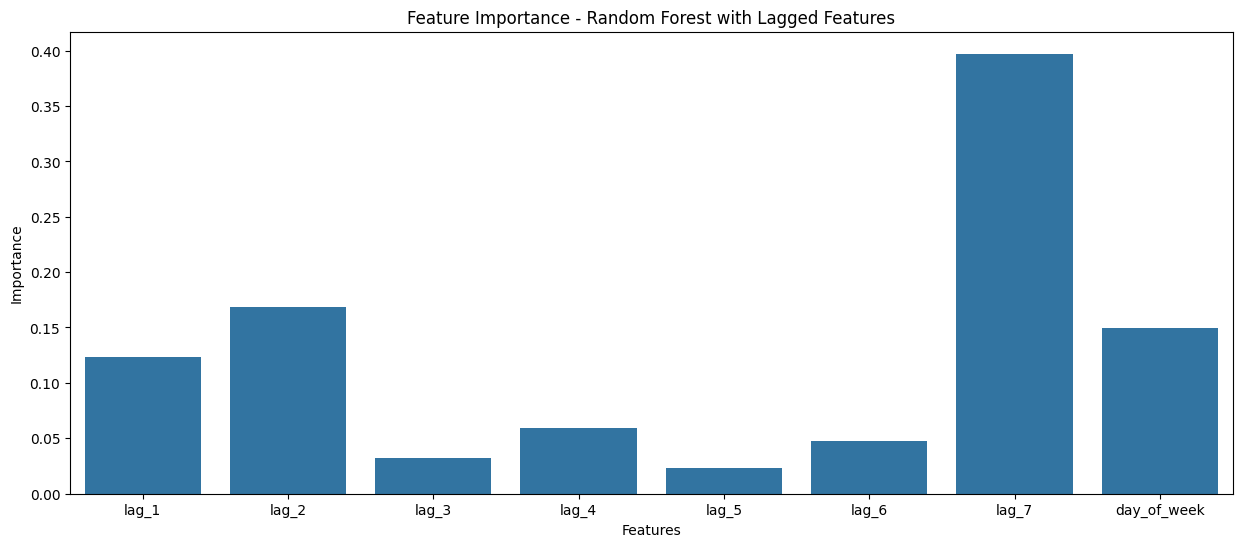

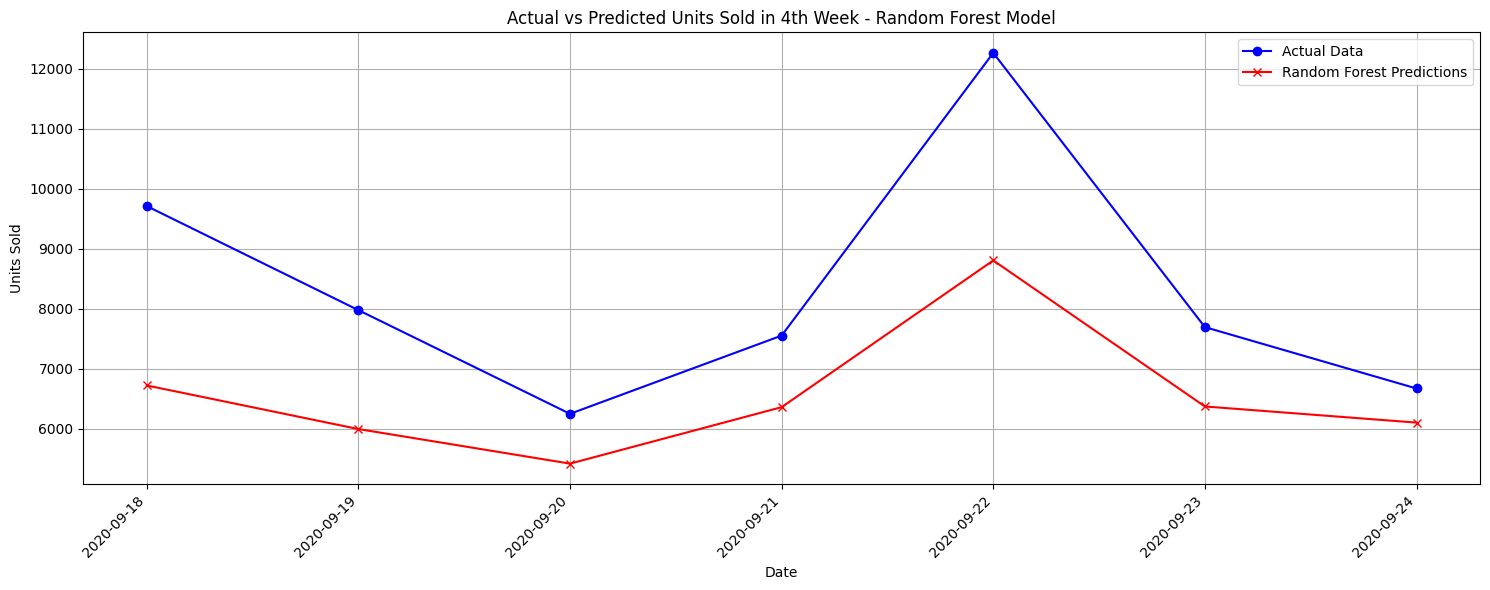


Evaluation Metrics:
MAE for Random Forest: 1762.4614285714285
RMSE for Random Forest: 2034.7291056235051
MAPE for Random Forest: 0.1978987458562194


In [39]:
# Train the Random Forest model
# n_estimators are further selected based on manual search
rf_model = RandomForestRegressor(max_depth= None, min_samples_leaf= 1, min_samples_split = 2, n_estimators= 100, random_state = 42) # Hyper-parameters evaluated using grid-search
rf_model.fit(X_train, y_train)

# Predicting the last 7 days (test set)
rf_predictions = rf_model.predict(X_test)

# Feature Importance
feature_importance = rf_model.feature_importances_

# Plotting the feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=features, y=feature_importance)
plt.title('Feature Importance - Random Forest with Lagged Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Plotting the actual vs predicted data for the last 7 days
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Data', marker='o', color='blue')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', marker='x', color='red')

custom_plot("Random Forest")

error_metrics(y_test, rf_predictions, "Random Forest")

##### Including lagged features reduced the MAPE value from ~ 22% to ~ 19%

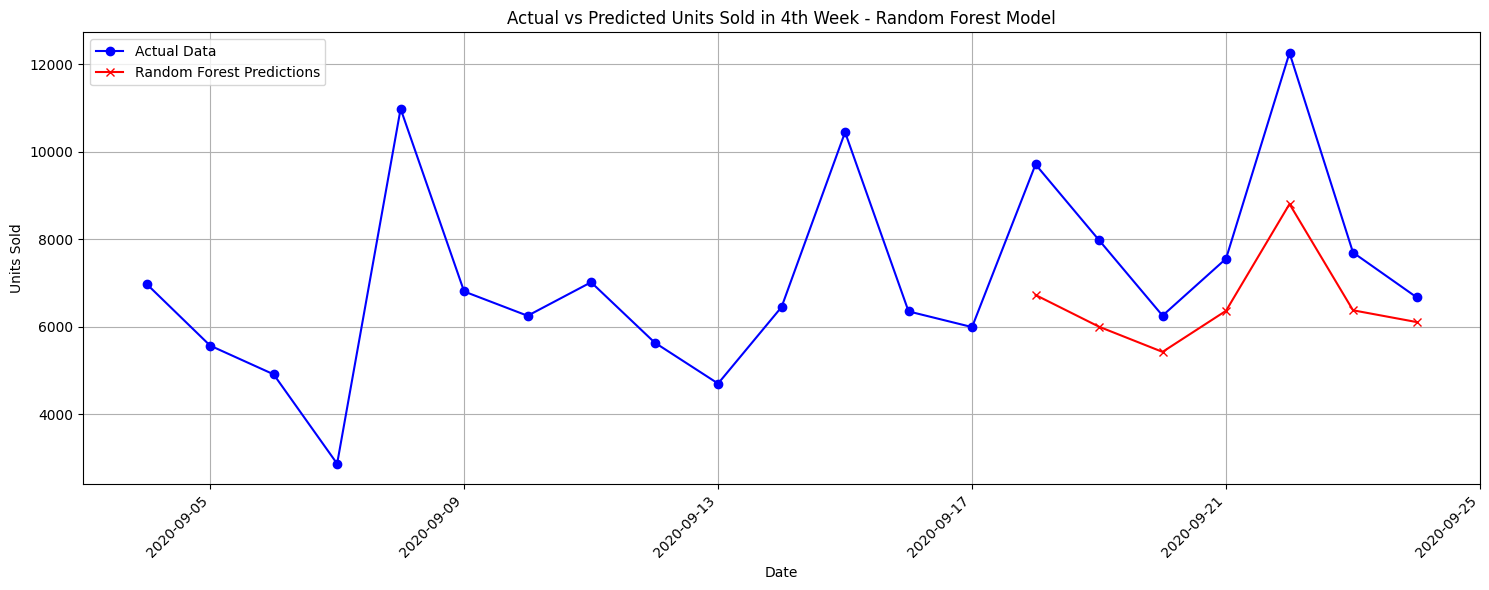

In [40]:
# Creating DataFrame for actual and predicted values

results_df = pd.DataFrame({
    'Actual': test_df['units_sold'].values,
    'Random Forest': rf_predictions
}, index=test_df.index)

# Plotting the actual vs predicted data for the last 7 days
plt.figure(figsize=(15, 6))
plt.plot(df_final.index, df_final['units_sold'], label='Actual Data', marker='o', color='blue')
plt.plot(results_df.index, results_df['Random Forest'], label='Random Forest Predictions', marker='x', color='red')

custom_plot("Random Forest")

#### XGBoost Model

In [41]:
# creating a copy of final_df to keep the original df intact
working_df = final_df.copy()

# Creating lagged features for the previous 7 days
for i in range(1, 8):
    working_df[f'lag_{i}'] = working_df['units_sold'].shift(i)

# Include the day of the week as an additional feature
working_df['day_of_week'] = working_df.index.dayofweek

# Drop any rows with NaN values resulting from the lagging operation
working_df = working_df.dropna()

In [42]:
working_df.head()

,units_sold,units_sold_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,day_of_week
TRANSACTION_DATE,,,,,,,,,,
2020-09-04,6975,1638.0,5337.0,5744.0,9920.0,5837.0,4141.0,5315.0,6552.0,4
2020-09-05,5565,-1410.0,6975.0,5337.0,5744.0,9920.0,5837.0,4141.0,5315.0,5
2020-09-06,4908,-657.0,5565.0,6975.0,5337.0,5744.0,9920.0,5837.0,4141.0,6
2020-09-07,2863,-2045.0,4908.0,5565.0,6975.0,5337.0,5744.0,9920.0,5837.0,0
2020-09-08,10984,8121.0,2863.0,4908.0,5565.0,6975.0,5337.0,5744.0,9920.0,1


#### Feature Importance

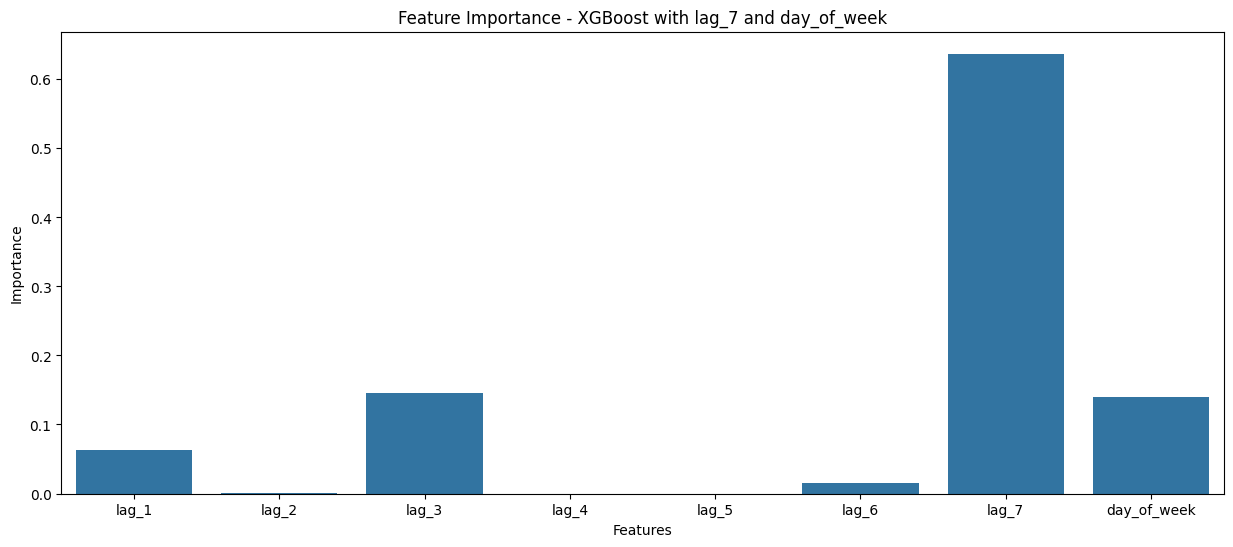

In [43]:
# Split the data: use the last 7 points as the test set
train_df = working_df.iloc[:-7]
test_df = working_df.iloc[-7:]

# Features to use: lagged data of 7 days and day_of_week
features = [f'lag_{i}' for i in range(1, 8)] + ['day_of_week']

X_train = train_df[features]
y_train = train_df['units_sold']

X_test = test_df[features]
y_test = test_df['units_sold']

# Training the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predicting the last 7 days (test set)
xgb_predictions = xgb_model.predict(X_test)

# Feature importance
feature_importance = xgb_model.feature_importances_

# Plotting the feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=features, y=feature_importance)
plt.title('Feature Importance - XGBoost with lag_7 and day_of_week')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


##### From the above plot, we can infer that the number of sold items in the previous day is a significant feature, we can include "lag_7" and "day_of week" feature

In [44]:
# Split the data: use the last 7 points as the test set
train_df = working_df.iloc[:-7]
test_df = working_df.iloc[-7:]

# Features to use: Only lag_7 and day_of_week
features = ['lag_7', 'day_of_week']

X_train = train_df[features]
y_train = train_df['units_sold']

X_test = test_df[features]
y_test = test_df['units_sold']

In [45]:
#### Performing Grid Search to identify best hyper-parameters for XGBoostRegressor

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7, 10],           # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],         # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0]   # Subsample ratio of columns when constructing each tree
}

# Initialize the XGBRegressor
xgb = XGBRegressor(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


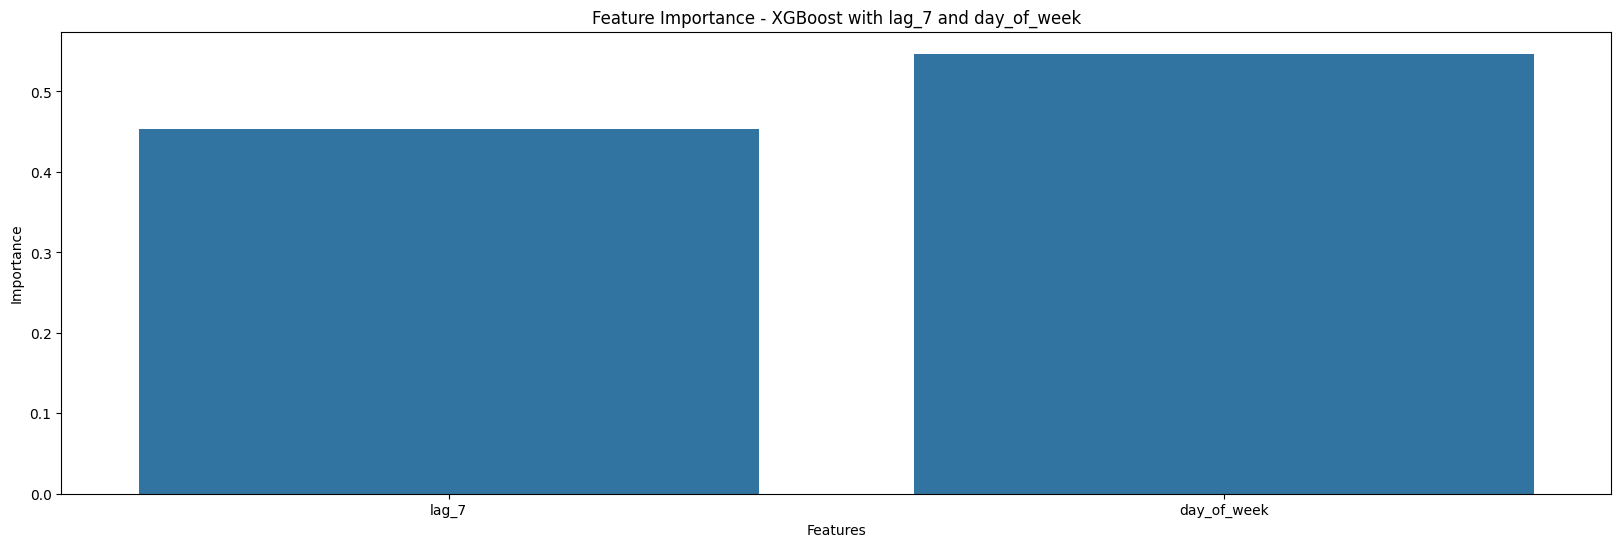

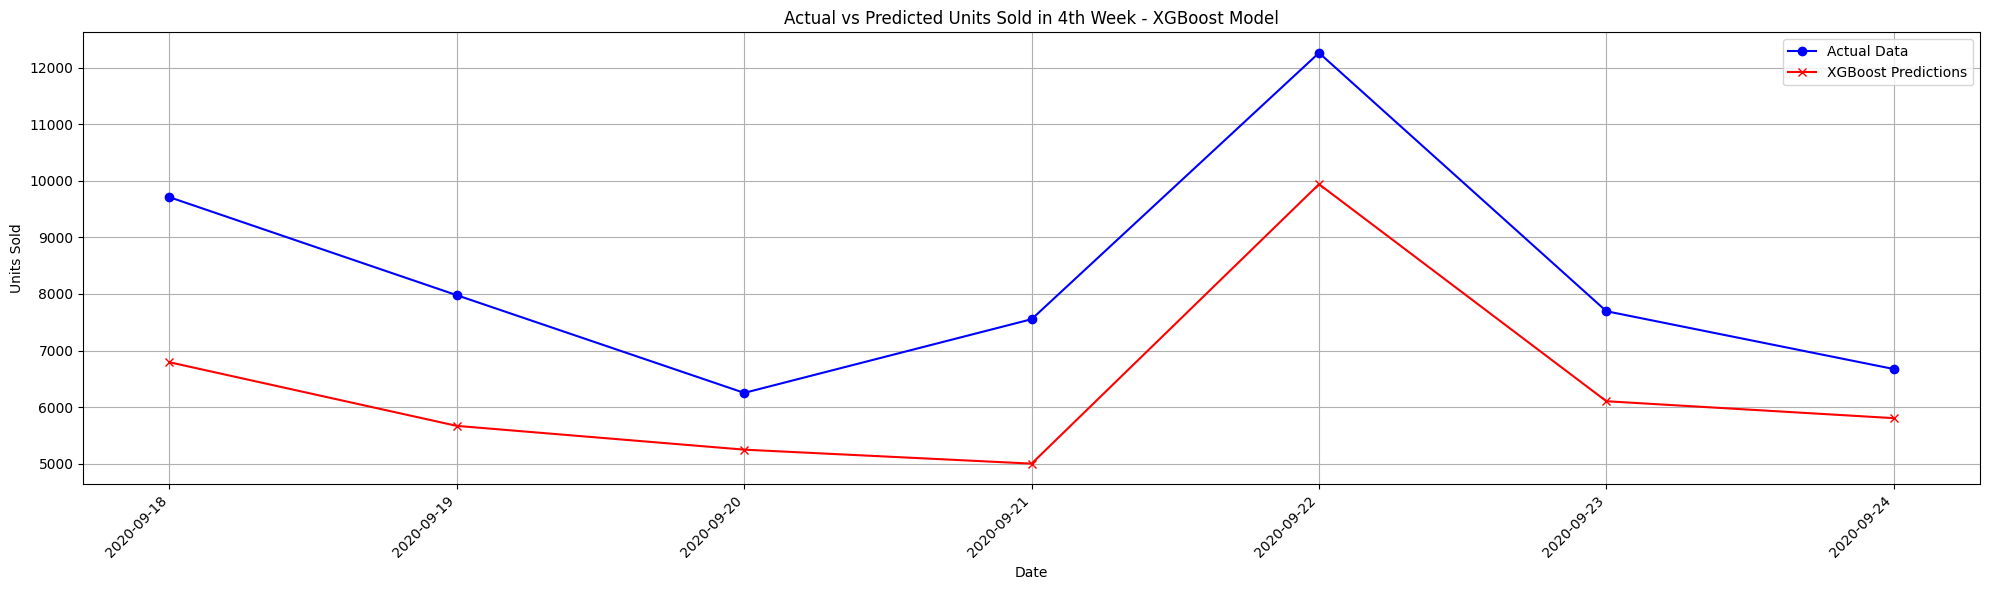


Evaluation Metrics:
MAE for XGBoost: 1938.3627232142858
RMSE for XGBoost: 2072.3978334663116
MAPE for XGBoost: 0.23073120817764317


In [46]:
# Train the XGBoost model with updated features
xgb_model = XGBRegressor(colsample_bytree= 0.6, learning_rate= 0.05, max_depth= 3, n_estimators= 50, subsample= 1.0, random_state=42)
xgb_model.fit(X_train, y_train)

# Predicting the last 7 days (test set)
xgb_predictions = xgb_model.predict(X_test)

# Feature importance
feature_importance = xgb_model.feature_importances_

# Plotting the feature importance
plt.figure(figsize=(20, 6))
sns.barplot(x=features, y=feature_importance)
plt.title('Feature Importance - XGBoost with lag_7 and day_of_week')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Plotting the actual vs predicted data for the last 7 days
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Actual Data', marker='o', color='blue')
plt.plot(y_test.index, xgb_predictions, label='XGBoost Predictions', marker='x', color='red')

custom_plot("XGBoost")

error_metrics(y_test, xgb_predictions, "XGBoost")


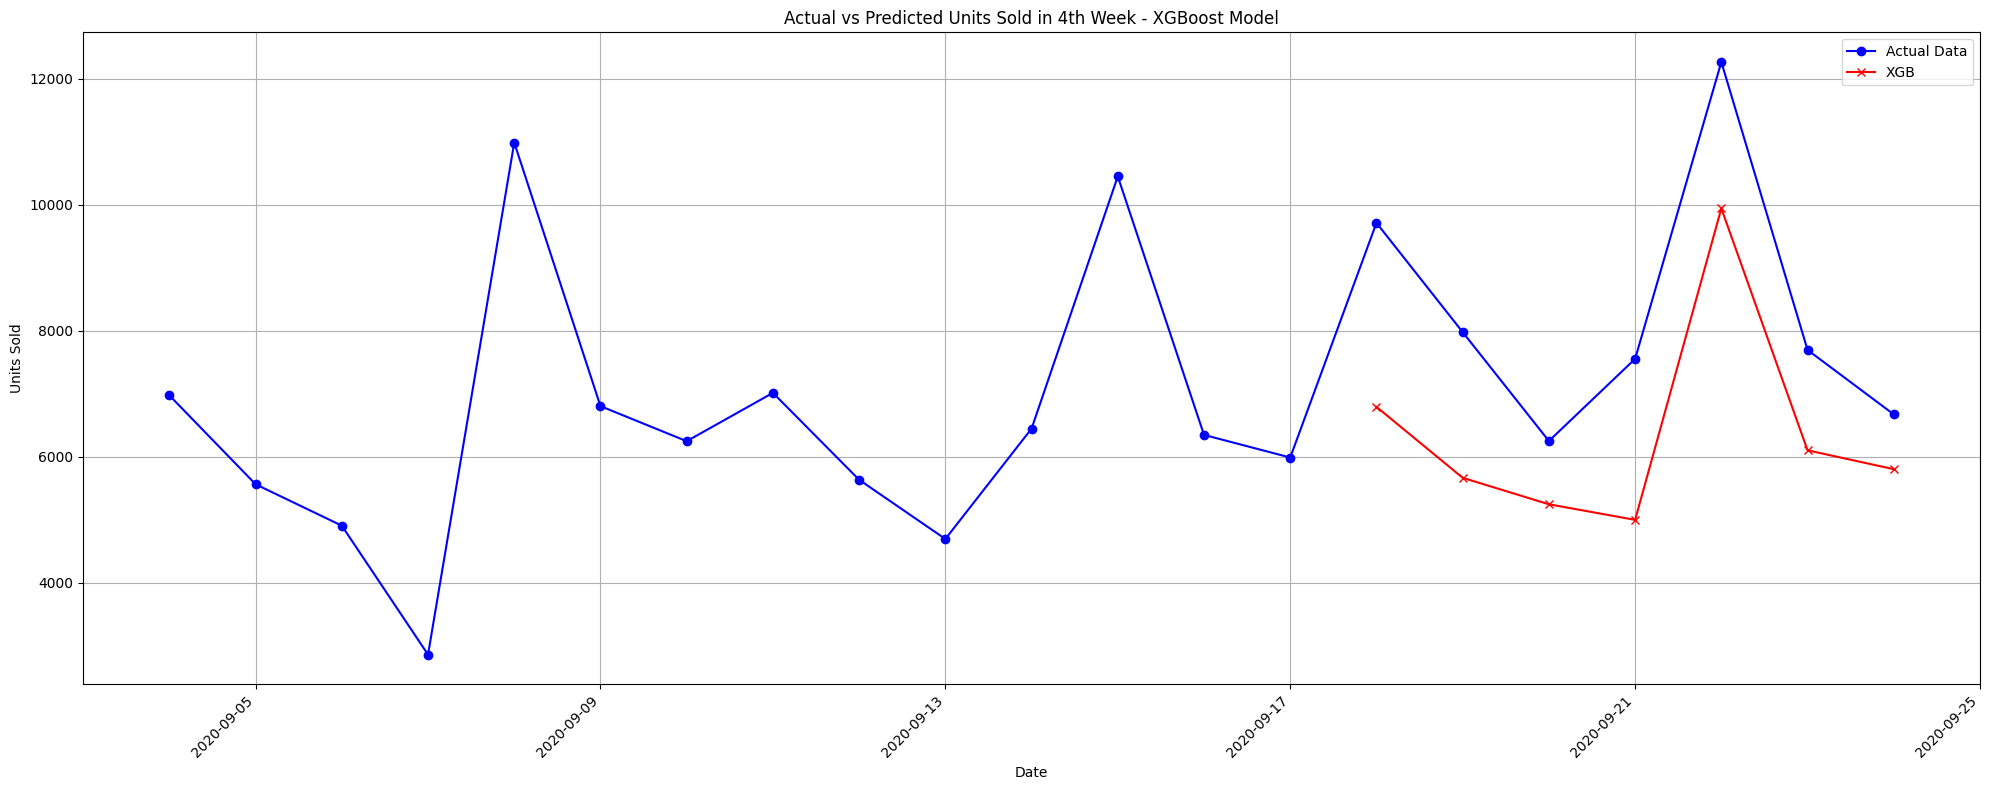

In [47]:
# Combine actual and predicted values into a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': test_df['units_sold'].values,
    'XGBoost': xgb_predictions
}, index=test_df.index)

# Plotting the actual vs predicted data for the last 7 days
plt.figure(figsize=(20, 8))
plt.plot(df_final.index, df_final['units_sold'], label='Actual Data', marker='o', color='blue')
plt.plot(results_df.index, results_df['XGBoost'], label='XGB', marker='x', color='red')

custom_plot("XGBoost")

### 11. Results Visualization

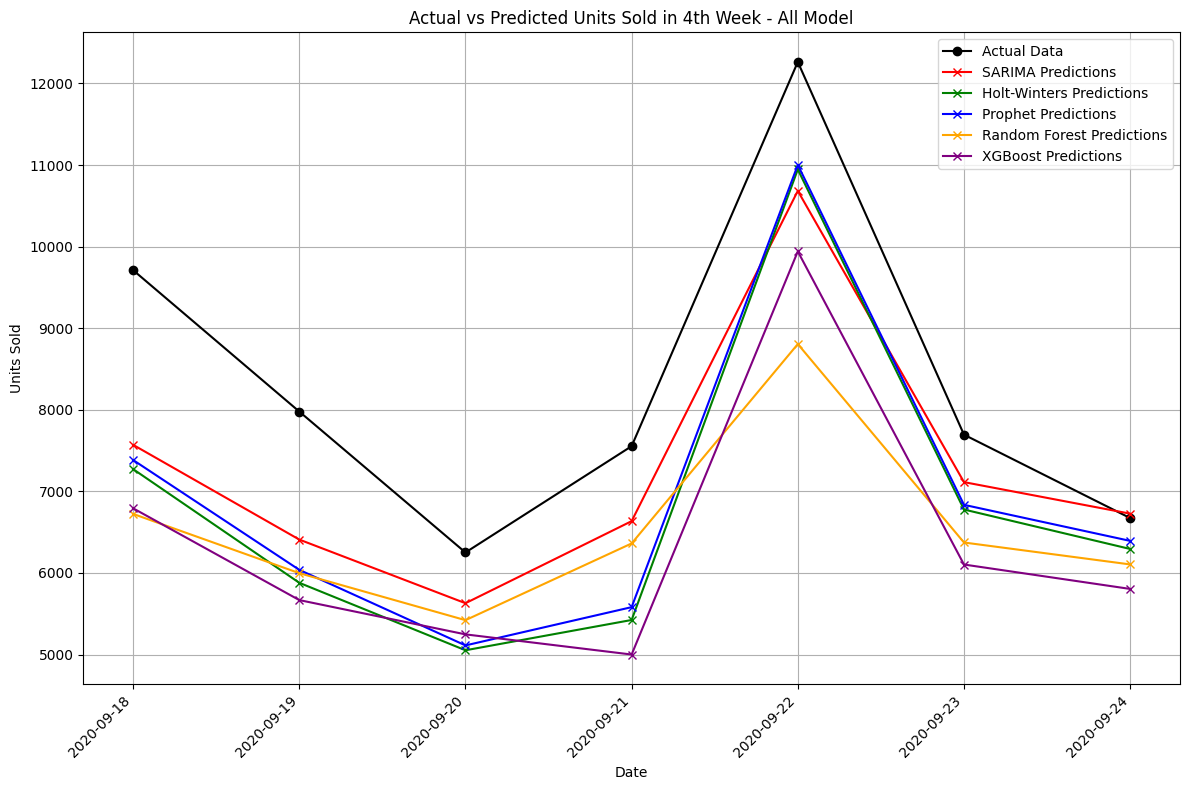

In [48]:
# Combining Predictions into a DataFrame
predictions_df = pd.DataFrame({
    'Actual': test_data.values,
    'SARIMA': predictions.values,
    'Holt-Winters': hw_forecast.values,
    'Prophet': prophet_predictions.values,
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions
}, index=test_data.index)

# Plotting the actual vs predicted data for all models
plt.figure(figsize=(12, 8))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual Data', marker='o', color='black')
plt.plot(predictions_df.index, predictions_df['SARIMA'], label='SARIMA Predictions', marker='x', color='red')
plt.plot(predictions_df.index, predictions_df['Holt-Winters'], label='Holt-Winters Predictions', marker='x', color='green')
plt.plot(predictions_df.index, predictions_df['Prophet'], label='Prophet Predictions', marker='x', color='blue')
plt.plot(predictions_df.index, predictions_df['Random Forest'], label='Random Forest Predictions', marker='x', color='orange')
plt.plot(predictions_df.index, predictions_df['XGBoost'], label='XGBoost Predictions', marker='x', color='purple')

custom_plot("All")

### 12. Metrics Report

In [49]:
# Printing metrics Report

predictions_metrics = {
    'SARIMA': predictions.values,
    'Holt-Winters': hw_forecast.values,
    'Prophet': prophet_predictions.values,
    'Random Forest': rf_predictions, #np array hence dont need .values
    'XGBoost': xgb_predictions  #np array hence dont need .values
}

metrics_df = calculate_error_metrics(test_data, predictions_metrics)
print(metrics_df)


The best model based on MAPE is: SARIMA
           Model          MAE         RMSE      MAPE
0         SARIMA  1066.509587  1259.939103  0.121526
1   Holt-Winters  1497.039956  1649.437338  0.181613
2        Prophet  1397.257092  1548.209343  0.168970
3  Random Forest  1762.461429  2034.729106  0.197899
4        XGBoost  1938.362723  2072.397833  0.230731


##### We will now use the two best models, **SARIMA** and **Prophet**, to train on the entire dataset.


### 13. Predicting the future with SARIMAX

C:\Users\Shreya\anaconda3_new\envs\TSF\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shreya\anaconda3_new\envs\TSF\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shreya\anaconda3_new\envs\TSF\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


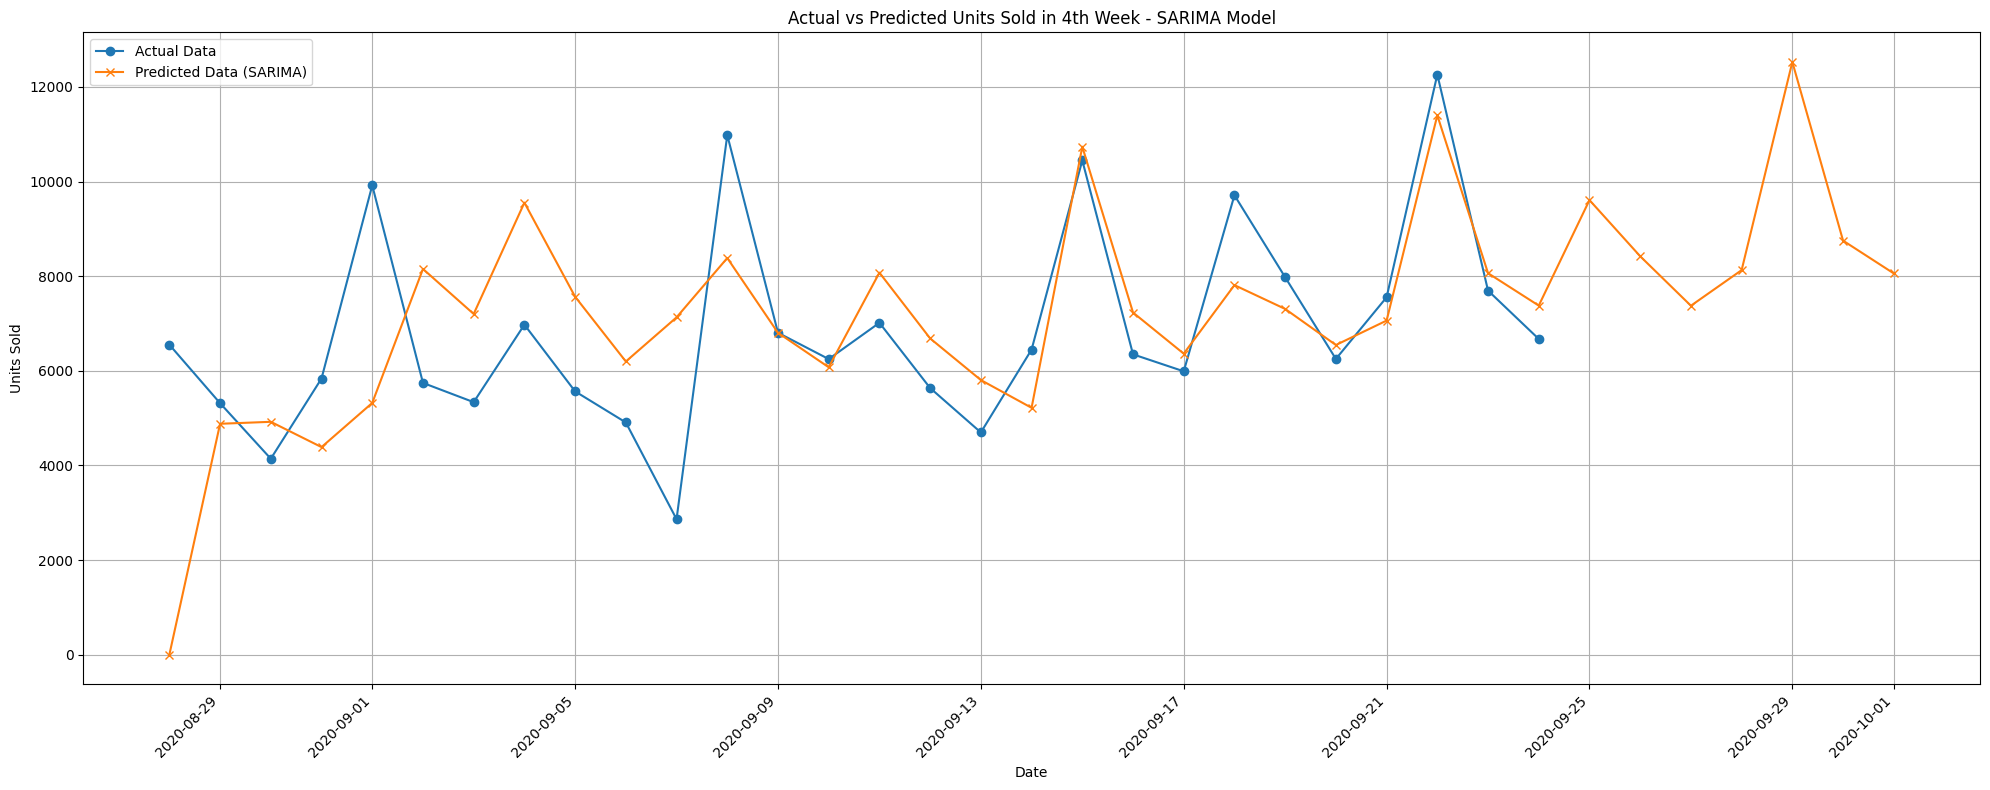


Evaluation Metrics:
MAE for SARIMAX: 1510.286701082781
RMSE for SARIMAX: 2115.5442886338883
MAPE for SARIMAX: 0.25382279619397763


In [50]:
# Fitting the SARIMA model (using the best parameters identified earlier)
model = SARIMAX(final_df['units_sold'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

# Prediction over the entire historical period
historical_predictions = model_fit.predict(start=0, end=len(final_df) - 1, dynamic=False)

# Forecasting into the future (next 7 days)
future_predictions = model_fit.get_forecast(steps=7)
future_index = pd.date_range(start=final_df.index[-1] + pd.Timedelta(days=1), periods=7)
forecasted_values = future_predictions.predicted_mean
forecasted_values.index = future_index

# Combining historical and future predictions
full_predictions = pd.concat([historical_predictions, forecasted_values])

# Plotting the actual vs predicted data
plt.figure(figsize=(20, 8))
plt.plot(final_df.index,final_df['units_sold'], label='Actual Data', marker='o', linestyle='-')
plt.plot(full_predictions.index, full_predictions, label='Predicted Data (SARIMA)', marker='x', linestyle='-')

custom_plot("SARIMA")

error_metrics(final_df['units_sold'], historical_predictions, "SARIMAX")

In [51]:
#sarimax
sarimax_preds = pd.DataFrame(full_predictions).tail(7).astype('int')
sarimax_preds

,predicted_mean
2020-09-25,9609
2020-09-26,8421
2020-09-27,7375
2020-09-28,8128
2020-09-29,12528
2020-09-30,8751
2020-10-01,8058


### 14. Predicting the future with Prophet

13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:52 - cmdstanpy - INFO - Chain [1] done processing


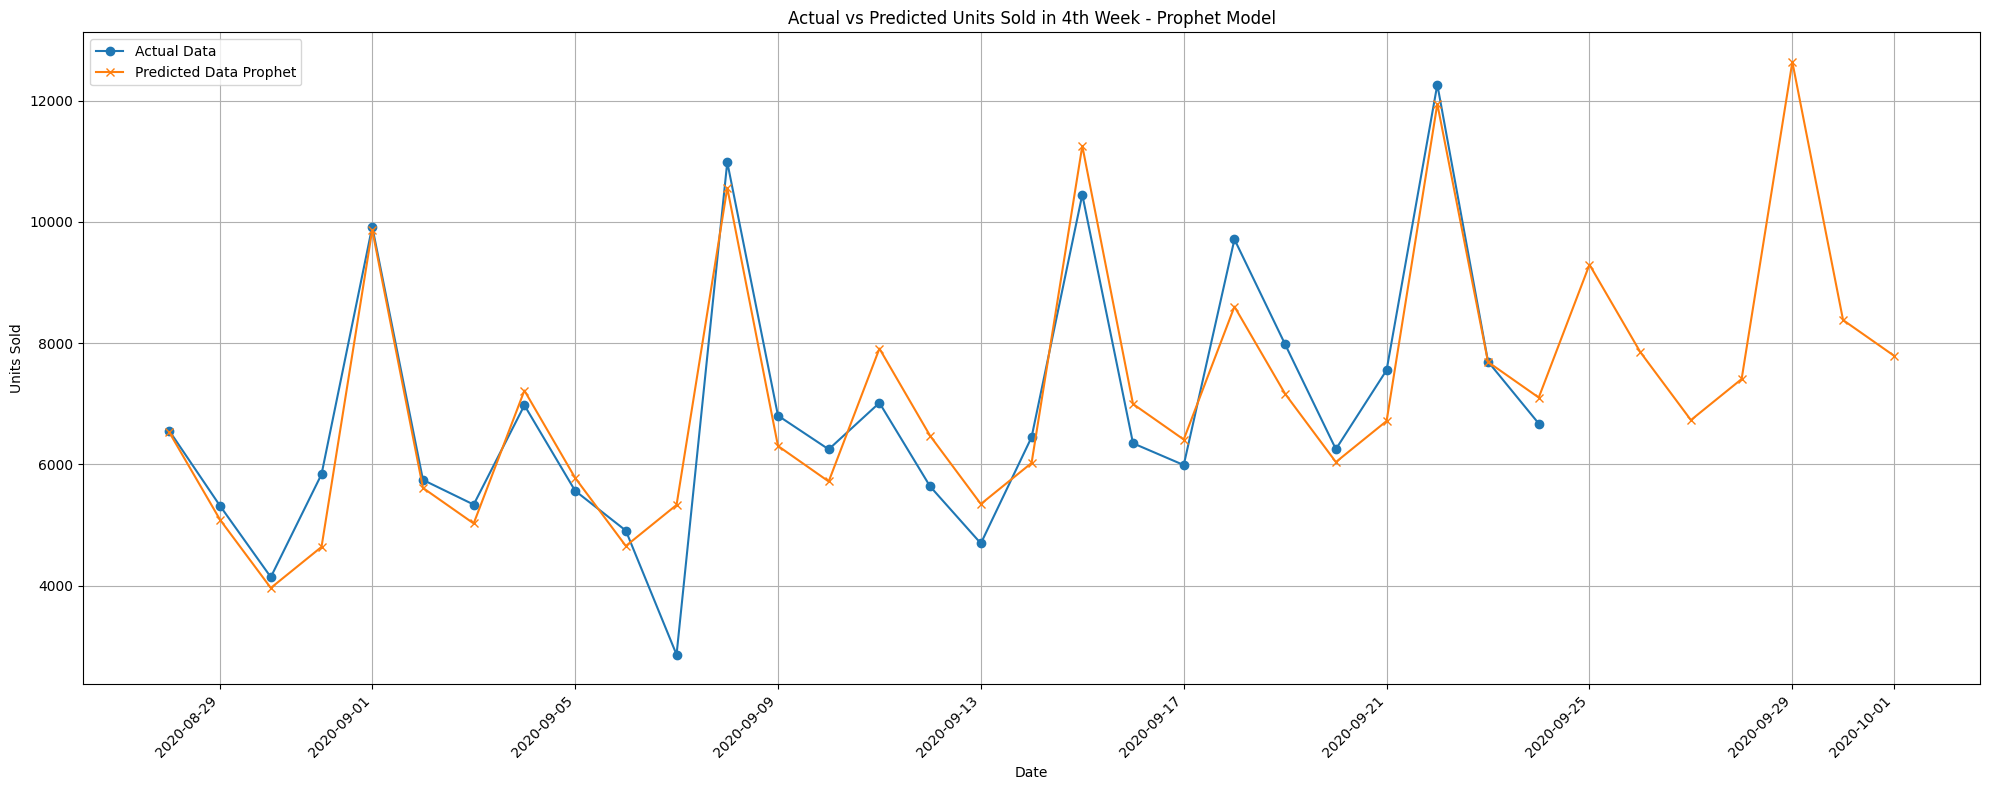


Evaluation Metrics:
MAE for Prophet: 477.96391283361635
RMSE for Prophet: 573.9525987725233
MAPE for Prophet: 0.06314356277340774


In [52]:
# Prepare the Data
df_prophet = final_df.reset_index().rename(columns={'TRANSACTION_DATE': 'ds', 'units_sold': 'y'})

# Prophet Model
model = Prophet(
    growth='linear',
    seasonality_mode='additive',
    weekly_seasonality=True,
    yearly_seasonality=False
)

# Adjusting Fourier order for weekly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=5)

# Fit the model
model.fit(df_prophet)

# Make Predictions
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

# Evaluate and Visualize
predicted = forecast[['ds', 'yhat']].tail(7).set_index('ds')
actual = df_prophet.set_index('ds').tail(7)

plt.figure(figsize=(20, 8))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual Data', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Data Prophet', marker='x')

custom_plot("Prophet")

error_metrics(actual['y'], predicted['yhat'], "Prophet")

### 15. Finalzing Results

In [53]:
#prophet
final_results = forecast[['ds', 'yhat']].tail(7).reset_index(drop=True)
final_results = final_results.rename(columns={'ds': 'Transaction_date', 'yhat': 'units_sold'})

# Rounding off the units to a whole number
final_results['units_sold'] = final_results['units_sold'].round().astype(int)

final_results.set_index('Transaction_date')

,units_sold
Transaction_date,
2020-09-25,9294
2020-09-26,7855
2020-09-27,6731
2020-09-28,7407
2020-09-29,12636
2020-09-30,8380
2020-10-01,7794


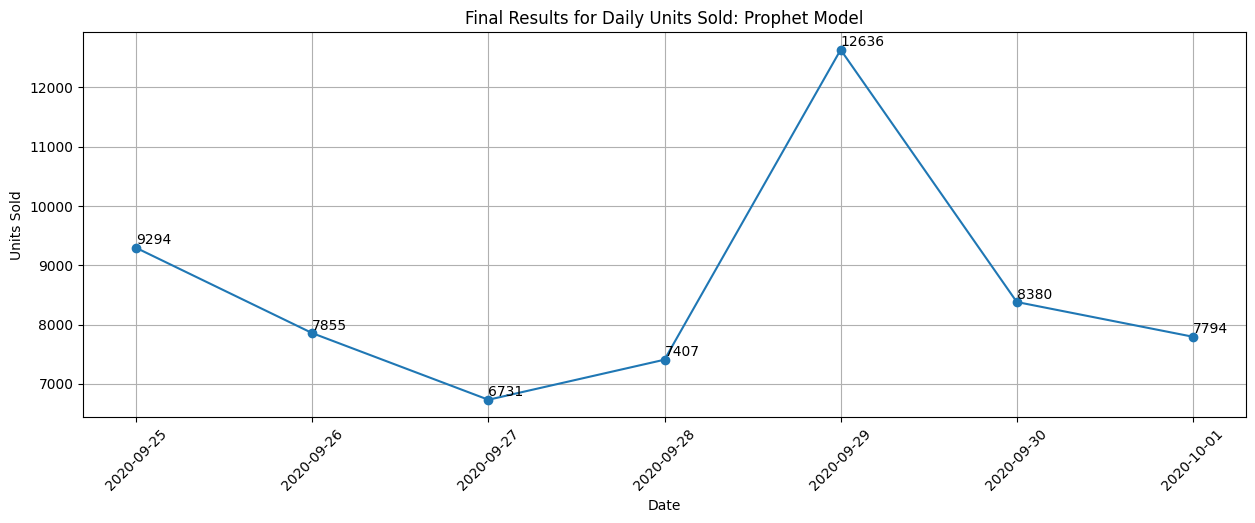

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(final_results['Transaction_date'], final_results['units_sold'], marker='o')

# Adding text annotations
for i in range(len(final_results)):
    plt.text(final_results['Transaction_date'].iloc[i], 
             final_results['units_sold'].iloc[i] + 60,  # Adjust the +50 as needed to move text above the marker
             str(final_results['units_sold'].iloc[i]), 
             fontsize=10, 
             ha='left')  # Center the text horizontally

plt.title('Final Results for Daily Units Sold: Prophet Model')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


### 16. Conclusion

Two models, **Prophet** and **SARIMAX**, were evaluated for time series forecasting using a 21-to-7 train-test split and full-data training with next-week prediction.

**21-to-7 Train-Test Split:**

|      Model       |         MAE         |        RMSE        |   MAPE   |
|:----------------:|:-------------------:|:------------------:|:--------:|
|       SARIMA     |   1066.509587       |   1259.939103       |  0.121526|
|   Holt-Winters   |   1497.039956       |   1649.437338       |  0.181613|
|      Prophet     |   1397.257092       |   1548.209343       |  0.168970|
|  Random Forest   |   1762.461429       |   2034.729106       |  0.197899|
|      XGBoost     |   1938.362723       |   2072.397833       |  0.230731|

**Full-Data Training:**

|      Model       |         MAE         |        RMSE        |   MAPE   |
|:----------------:|:-------------------:|:------------------:|:--------:|
|  **Prophet**     |   **477.96**        |   **573.95**        |  **6.31%** |
|     SARIMAX      |   1510.29           |   2115.54           |  25.38%  |

**Why Prophet Outperformed:**
- **Prophet** outperformed **SARIMAX** when trained on the full dataset due to its ability to handle complex seasonality, trends, and changepoints, which are critical in capturing the long-term patterns present in the data.

**Final Model Choice:**
- **Prophet** was chosen as the final model because it provided significantly better accuracy (lower MAE, RMSE, and MAPE) when using all available data. Its robustness and flexibility make it more suitable for accurate long-term forecasting in this scenario.
